In [1]:
import os.path
import datetime
from pathlib import Path

# essentials
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tensorflow tools
import keras
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras import Model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Add, Activation, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import plot_model

In [2]:
base_dir = './data/Fruits-360/fruits-360_dataset/fruits-360'

train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

In [3]:
train_filepaths = list(Path(train_dir).glob(r'**/*.jpg'))
test_filepaths = list(Path(test_dir).glob(r'**/*.jpg'))

In [4]:
def get_fruit_label(filepaths):
    labels = [str(filepath).split('\\')[-2].split(' ')[0] for _, filepath in enumerate(filepaths)]

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    fruits_df = pd.concat([filepaths, labels], axis=1)

    return fruits_df

In [5]:
train_df = get_fruit_label(train_filepaths)
test_df = get_fruit_label(test_filepaths)

In [6]:
label_list = train_df.Label.unique().tolist()

In [7]:
# label_list = os.listdir(test_dir)

In [8]:
image_size = (299, 299, 3)
batch_size = 32
num_classes = len(label_list)

In [9]:
train_datagen = image.ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=[1, 2],
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = image.ImageDataGenerator()

In [10]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    target_size=image_size[:-1]
)

validation_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    target_size=image_size[:-1]
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    target_size=image_size[:-1]
)

Found 54154 validated image filenames belonging to 67 classes.
Found 13538 validated image filenames belonging to 67 classes.
Found 22688 validated image filenames belonging to 67 classes.


In [57]:
# train_gen = train_datagen.flow_from_directory(
#     train_dir,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True,
#     target_size=image_size[:-1]
# )
#
# validation_gen = train_datagen.flow_from_directory(
#     train_dir,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=True,
#     target_size=image_size[:-1]
# )
#
# test_gen = test_datagen.flow_from_directory(
#     test_dir,
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=True,
#     target_size=image_size[:-1]
# )

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


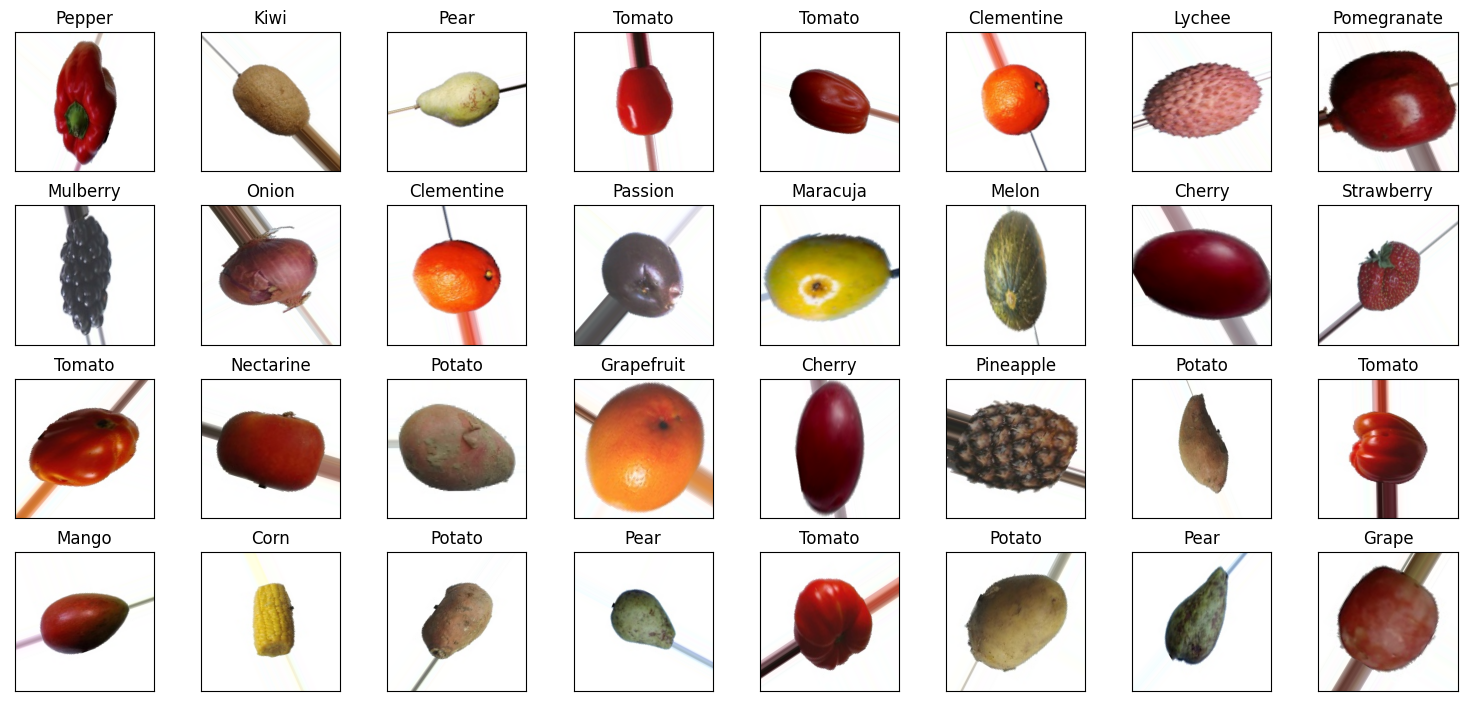

In [11]:
X_sample, y_sample = train_gen.next()

fig, axes = plt.subplots(4, 8, figsize=(15, 7), subplot_kw={'xticks' : [], 'yticks' : []})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_sample[i]/255.)
    ax.set_title(label_list[np.argmax(y_sample[i])])
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
def build_model(pretrained_model):
    x = Dense(256, activation='relu')(pretrained_model.output)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=pretrained_model.input, outputs=output)

In [11]:
train_datagen.preprocessing_function = vgg16_preprocess
test_datagen.preprocessing_function = vgg16_preprocess

In [12]:
pretrained_model_vgg16 = VGG16(
    input_shape=image_size,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_vgg16.trainable = False

In [13]:
model_vgg16 = build_model(pretrained_model_vgg16)
model_vgg16.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
log_dir = "logs/VGG16/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
model_vgg16.fit(train_gen, validation_data=validation_gen, epochs=1, callbacks=[tensorboard_callback])

1694/1694 [==============================] - 795s 465ms/step - loss: 0.2731 - accuracy: 0.9356 - val_loss: 0.0517 - val_accuracy: 0.9826


In [16]:
loss_vgg16, accuracy_vgg16 = model_vgg16.evaluate(test_gen)

709/709 [==============================] - 259s 364ms/step - loss: 0.1078 - accuracy: 0.9680


In [ ]:
test_datagen.preprocessing_function = None
X_sample, y_sample = test_gen.next()

apply_preprocess = np.vectorize(xception_preprocess)
predictions_vgg16 = model_vgg16.predict(apply_preprocess(X_sample), verbose=0)

fig, axes = plt.subplots(4, 8, figsize=(15, 7), subplot_kw={'xticks' : [], 'yticks' : []})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_sample[i]/255.)
    ax.set_title(f'True: {label_list[np.argmax(y_sample[i])]}\nPredicted: {label_list[np.argmax(predictions_vgg16[i])]}', fontsize=8)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_datagen.preprocessing_function = xception_preprocess
test_datagen.preprocessing_function = xception_preprocess

In [ ]:
pretrained_model_xception = Xception(
    input_shape=image_size,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_xception.trainable = False

In [ ]:
model_xception = build_model(pretrained_model_xception)
model_xception.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
log_dir = "logs/Xception/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model_xception.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=1, callbacks=[tensorboard_callback])

In [ ]:
loss_xception, accuracy_xception = model_xception.evaluate(test_gen)

In [ ]:
test_datagen.preprocessing_function = None
X_sample, y_sample = test_gen.next()

apply_preprocess = np.vectorize(xception_preprocess)
predictions_xception = model_xception.predict(apply_preprocess(X_sample), verbose=0)

fig, axes = plt.subplots(4, 8, figsize=(15, 7), subplot_kw={'xticks' : [], 'yticks' : []})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_sample[i]/255.)
    ax.set_title(f'True: {label_list[np.argmax(y_sample[i])]}\nPredicted: {label_list[np.argmax(predictions_xception[i])]}', fontsize=8)
plt.tight_layout(pad=0.5)
plt.show()

In [15]:
def custom_preprocess(input_image):
    return imagenet_utils.preprocess_input(input_image, mode='tf')

In [16]:
train_datagen.preprocessing_function = custom_preprocess
test_datagen.preprocessing_function = custom_preprocess

In [17]:
def custom_block(input_layer, filters, name=None):
    padding = 'same'
    f1, f2, f3, f4 = filters

    input_shortcut = input_layer

    branch0 = Conv2D(filters=f1, kernel_size=(1, 1) , strides=(1, 1), padding=padding, activation='relu', name=name+'_b0')(input_layer)
    branch1 = Conv2D(filters=f2, kernel_size=(1, 1), strides=(1, 1), padding=padding, activation='relu', name=name+'_b1_0')(input_layer)
    branch1 = Conv2D(filters=f3, kernel_size=(3, 3), strides=(1, 1), padding=padding, activation='relu', name=name+'_b1_1')(branch1)

    mixed = Concatenate(axis=3, name=name+'_concat')([branch0, branch1])
    filexp = Conv2D(filters=f4, kernel_size=(1, 1), strides=(1, 1), padding=padding, name=name+'_filexp')(mixed)

    output = Add()([input_shortcut, filexp])
    output = Activation('relu')(output)

    return output

In [18]:
def custom_model(n_classes, input_shape=(299, 299, 3)):

    x_input = Input(input_shape)

    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu', name='conv1')(x_input)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', name='conv2')(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid', name='maxpool1')(x)

    x = custom_block(x, [32, 32, 64, 64], 'block1')
    x = custom_block(x, [128, 128, 256, 64], 'block2')

    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dropout(0.2, name='dropout1')(x)
    x = Dense(n_classes, activation='softmax', name='output')(x)

    model = Model(inputs=x_input, outputs=x)

    return model

In [19]:
model_custom = custom_model(num_classes, image_size)
model_custom.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

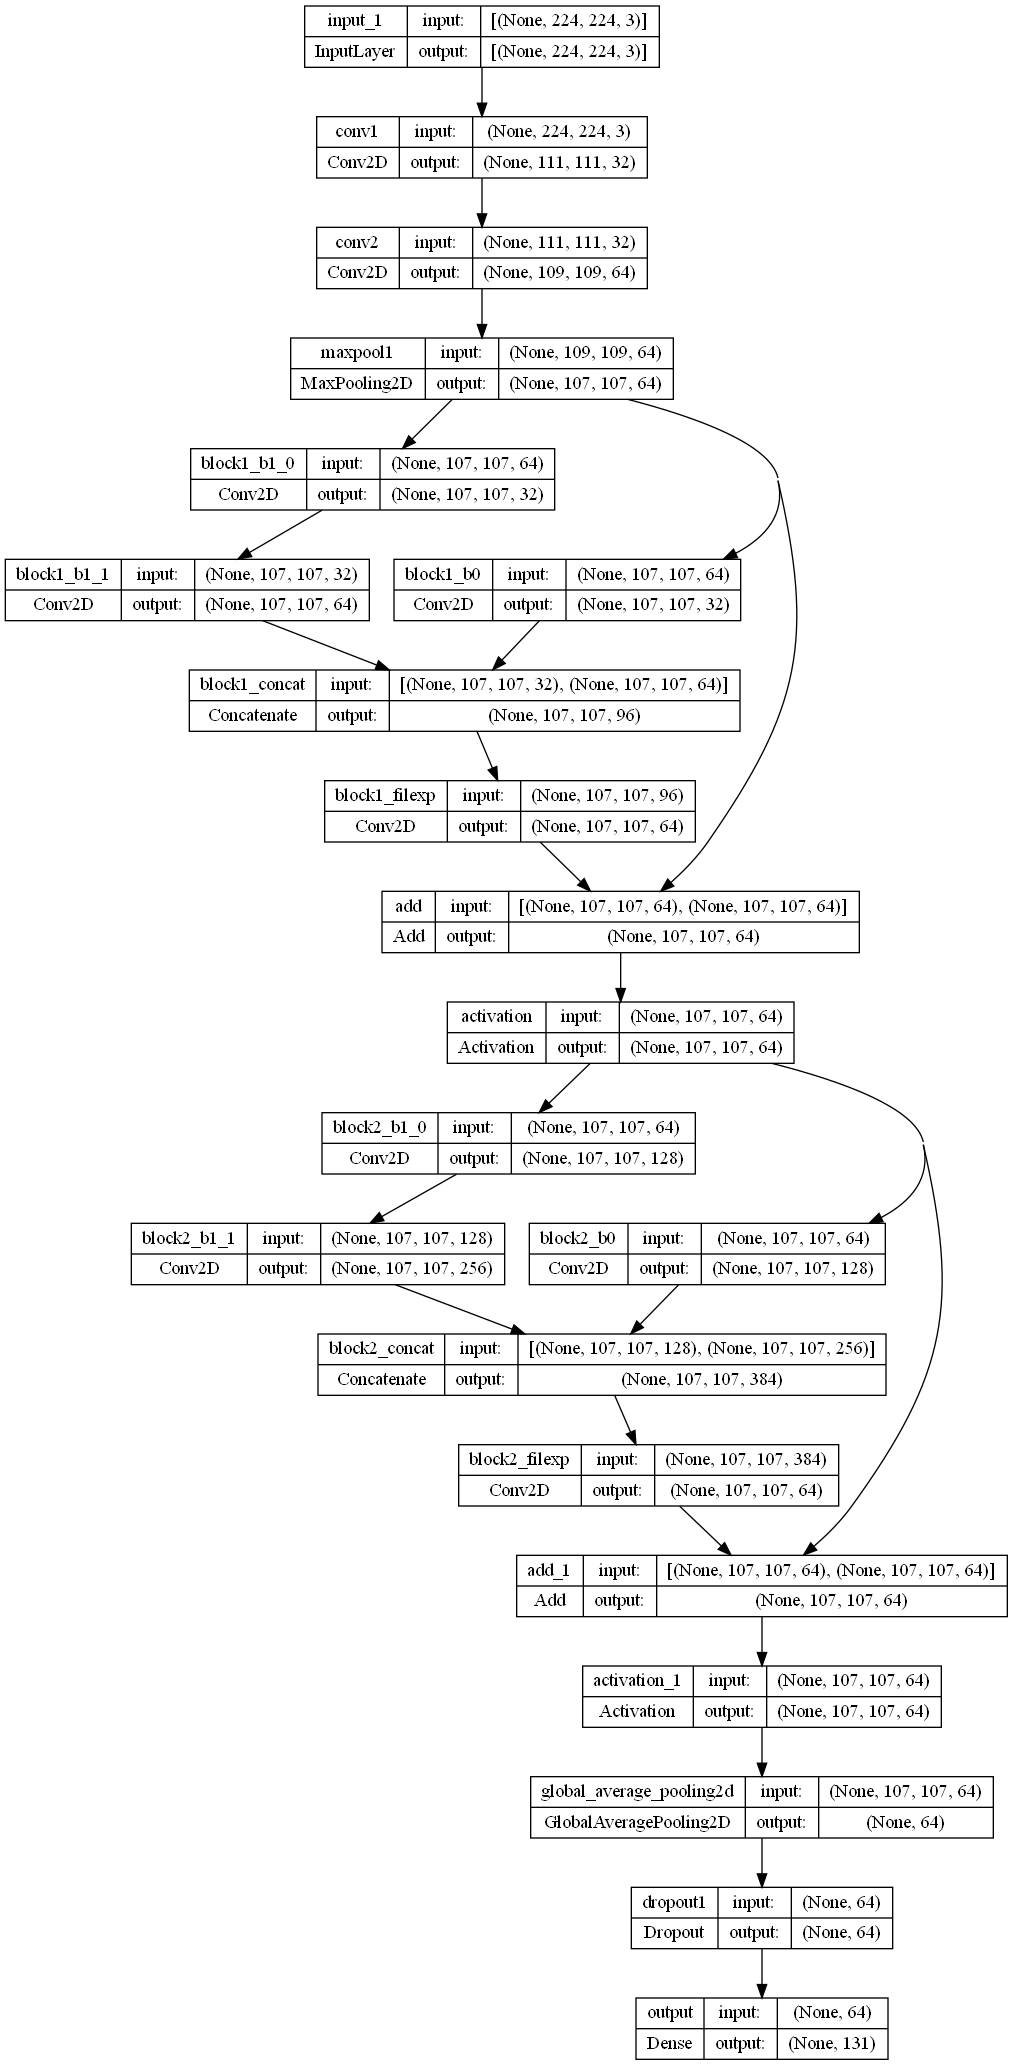

In [14]:
plot_model(model_custom, to_file='model.png', show_shapes=True, show_layer_names=True)

In [15]:
log_dir = "logs/Xception/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint('custom_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=4, restore_best_weights=True)

callbacks = [tensorboard_callback, checkpoint_callback, earlystopping_callback]

In [16]:
history_custom = model_custom.fit(train_gen, validation_data=validation_gen, epochs=25, callbacks=callbacks)

Epoch 1/25
1694/1694 [==============================] - ETA: 0s - loss: 1.6973 - accuracy: 0.5186
Epoch 1: val_accuracy improved from -inf to 0.79322, saving model to custom_model.h5
1694/1694 [==============================] - 534s 311ms/step - loss: 1.6973 - accuracy: 0.5186 - val_loss: 0.7372 - val_accuracy: 0.7932
Epoch 2/25
1694/1694 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8520
Epoch 2: val_accuracy improved from 0.79322 to 0.92727, saving model to custom_model.h5
1694/1694 [==============================] - 517s 305ms/step - loss: 0.4455 - accuracy: 0.8520 - val_loss: 0.2648 - val_accuracy: 0.9273
Epoch 3/25
1694/1694 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.9109
Epoch 3: val_accuracy improved from 0.92727 to 0.93919, saving model to custom_model.h5
1694/1694 [==============================] - 517s 305ms/step - loss: 0.2651 - accuracy: 0.9109 - val_loss: 0.2260 - val_accuracy: 0.9392
Epoch 4/25
1694/1694 [============

KeyboardInterrupt: 

In [20]:
model_custom.load_weights('custom_model.h5')

In [21]:
loss_custom, accuracy_custom = model_custom.evaluate(test_gen)

709/709 [==============================] - 106s 138ms/step - loss: 0.1186 - accuracy: 0.9717


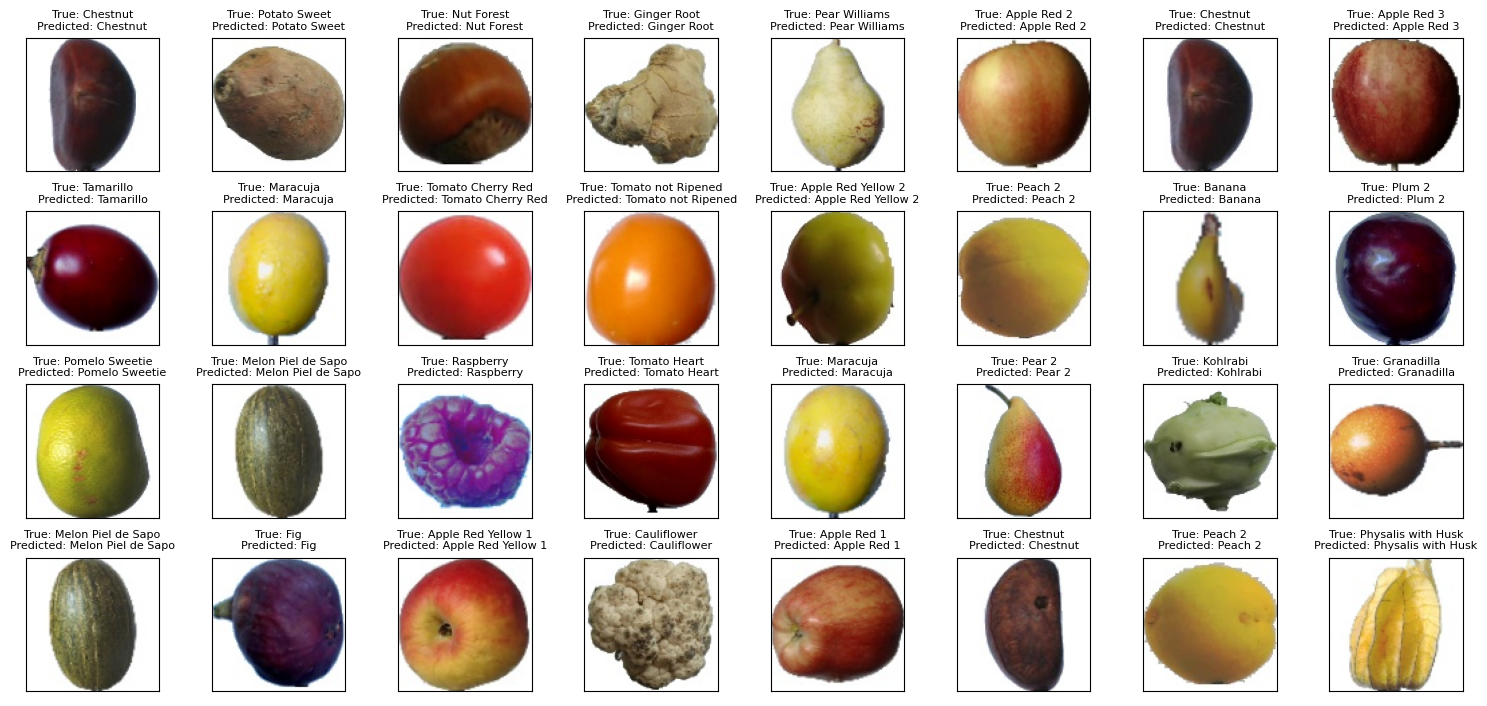

In [35]:
test_datagen.preprocessing_function = None
X_sample, y_sample = test_gen.next()

apply_preprocess = np.vectorize(custom_preprocess)
predictions_custom = model_custom.predict(apply_preprocess(X_sample), verbose=0)

fig, axes = plt.subplots(4, 8, figsize=(15, 7), subplot_kw={'xticks' : [], 'yticks' : []})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_sample[i]/255.)
    ax.set_title(f'True: {label_list[np.argmax(y_sample[i])]}\nPredicted: {label_list[np.argmax(predictions_custom[i])]}', fontsize=8)
plt.tight_layout(pad=0.5)
plt.show()